# Parse PATH monthly ridership PDF
```bash
papermill -p year $year [-p last_month $last_month] monthly.ipynb out/monthly-$year.ipynb
```

In [1]:
from utz import *
import json
from tabula import read_pdf

In [2]:
n = now()
cur_year = n.year
cur_month = n.month
cur_year, cur_month

(2024, 5)

Papermill parameters:

In [3]:
year = None
last_month = None
template = None

In [4]:
# Parameters
year = 2012


In [5]:
if year is None:
    year = cur_year

if last_month is None:
    if year == cur_year:
        last_month = 3
    else:
        last_month = 12

if template is None:
    if year >= 2023:
        template = '2023-PATH-Monthly-Ridership-Report.tabula-template.json'
    else:
        template = 'PATH-Monthly-Ridership-Report.json'

In [6]:
pdf = f'data/{year}-PATH-Monthly-Ridership-Report.pdf'
pdf

'data/2012-PATH-Monthly-Ridership-Report.pdf'

In [7]:
with open(f'templates/{template}', 'r') as f:
    rects = json.load(f)
rects

[{'y1': 121.284, 'x1': 70.016, 'y2': 245.247, 'x2': 568.926},
 {'y1': 261.316, 'x1': 71.546, 'y2': 407.469, 'x2': 569.691},
 {'y1': 482.459, 'x1': 70.781, 'y2': 603.36, 'x2': 568.161},
 {'y1': 620.96, 'x1': 70.781, 'y2': 761.757, 'x2': 569.691}]

In [8]:
area = [ [ r[k] for k in [ 'y1', 'x1', 'y2', 'x2' ] ] for r in rects ]
area

[[121.284, 70.016, 245.247, 568.926],
 [261.316, 71.546, 407.469, 569.691],
 [482.459, 70.781, 603.36, 568.161],
 [620.96, 70.781, 761.757, 569.691]]

In [9]:
tables = {
    month: read_pdf(
        pdf,
        pages=month,
        area=area,
        pandas_options={'header': None},
        stream=True,
    ) 
    for month in range(1, last_month + 1)
}

tables

Error importing jpype dependencies. Fallback to subprocess.


No module named 'jpype'


{1: [                    0          1        2       3       4       5
  0  Christopher Street    112,187    4,256   2,708   2,433   2,040
  1           9thStreet    126,682    4,483   3,695   3,436   2,533
  2          14thStreet    228,483    8,768   5,346   4,730   4,041
  3          23rdStreet    197,597    8,345   2,924   2,563   3,096
  4          33rdStreet    886,167   34,797  17,350  16,716  18,627
  5     UPTOWN SUBTOTAL  1,551,116   60,649  32,023  29,878  30,337
  6                 WTC  1,133,602   49,454  13,557  12,010  15,120
  7   NEW YORK SUBTOTAL  2,684,718  110,103  45,580  41,888  45,457,
                       0          1        2        3       4        5
  0               Newark    724,398   30,680   11,222   8,139   12,608
  1             Harrison    162,843    6,896    2,610   1,740    2,888
  2       Journal Square    654,366   25,962   13,967  10,205   14,114
  3         Grove Street    387,261   15,575    8,152   5,719    7,281
  4       Exchange Place    3

In [10]:
cols1 = [ 'station', 'total', 'avg weekday', 'avg sat', 'avg sun', 'avg holiday' ]
cols2 = [ 'station', 'avg daily', 'total weekday', 'total sat', 'total sun', 'total holiday' ]

In [11]:
for k, v in tables.items():
    n = len(v)
    msg = f'Pg {k}: {n} tables'
    if n == 4:
        print(msg)
    else:
        err(msg)
len(tables)

Pg 1: 4 tables
Pg 2: 4 tables
Pg 3: 4 tables
Pg 4: 4 tables
Pg 5: 4 tables
Pg 6: 4 tables
Pg 7: 4 tables
Pg 8: 4 tables
Pg 9: 4 tables
Pg 10: 4 tables
Pg 11: 4 tables
Pg 12: 4 tables


12

In [12]:
avgs = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[:2]
])
avgs['date'] = avgs.date.dt.date
avgs

,0,1,2,3,4,5,date
0,Christopher Street,"112,187","4,256","2,708","2,433","2,040",2012-01-01
1,9thStreet,"126,682","4,483","3,695","3,436","2,533",2012-01-01
2,14thStreet,"228,483","8,768","5,346","4,730","4,041",2012-01-01
3,23rdStreet,"197,597","8,345","2,924","2,563","3,096",2012-01-01
4,33rdStreet,"886,167","34,797","17,350","16,716","18,627",2012-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,"291,847","13,563","2,362","1,395","1,801",2012-12-01
5,Pavonia/ Newport,"453,522","19,405","6,388","5,672","5,118",2012-12-01
6,Hoboken,"114,339","4,246","2,863","2,613","2,050",2012-12-01
7,NEW JERSEY SUBTOTAL,"2,578,984","106,767","47,296","35,803","28,147",2012-12-01


In [13]:
avgs.columns = cols1 + ['month']
avgs = avgs.assign(**{
    k: avgs[k].astype(str).str.replace(',', '').astype(int)
    for k in cols1[1:]
})
avgs

,station,total,avg weekday,avg sat,avg sun,avg holiday,month
0,Christopher Street,112187,4256,2708,2433,2040,2012-01-01
1,9thStreet,126682,4483,3695,3436,2533,2012-01-01
2,14thStreet,228483,8768,5346,4730,4041,2012-01-01
3,23rdStreet,197597,8345,2924,2563,3096,2012-01-01
4,33rdStreet,886167,34797,17350,16716,18627,2012-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,291847,13563,2362,1395,1801,2012-12-01
5,Pavonia/ Newport,453522,19405,6388,5672,5118,2012-12-01
6,Hoboken,114339,4246,2863,2613,2050,2012-12-01
7,NEW JERSEY SUBTOTAL,2578984,106767,47296,35803,28147,2012-12-01


In [14]:
avgs.isna().sum(axis=0)

station        0
total          0
avg weekday    0
avg sat        0
avg sun        0
avg holiday    0
month          0
dtype: int64

In [15]:
avgs.dtypes

station        object
total           int64
avg weekday     int64
avg sat         int64
avg sun         int64
avg holiday     int64
month          object
dtype: object

In [16]:
sums = pd.concat([
    df.assign(date=to_dt(f'{year}-{month}'))
    for month, dfs in tables.items()
    for df in dfs[2:]
])
sums['date'] = sums.date.dt.date
sums.columns = cols2 + ['month']
sums = sums.assign(**{
    k: sums[k].astype(str).str.replace(',', '').astype(int)
    for k in cols2[1:]
})
sums

,station,avg daily,total weekday,total sat,total sun,total holiday,month
0,Christopher Street,3619,85113,10830,12163,4081,2012-01-01
1,9thStreet,4087,89658,14780,17178,5066,2012-01-01
2,14thStreet,7370,175369,21384,23648,8082,2012-01-01
3,23rdStreet,6374,166895,11698,12813,6191,2012-01-01
4,33rdStreet,28586,695937,69398,83578,37254,2012-01-01
...,...,...,...,...,...,...,...
4,Exchange Place,9414,271260,11812,6974,1801,2012-12-01
5,Pavonia/ Newport,14630,388103,31939,28362,5118,2012-12-01
6,Hoboken,3688,84913,14313,13063,2050,2012-12-01
7,NEW JERSEY SUBTOTAL,83193,2135345,236479,179013,28147,2012-12-01


In [17]:
sums.isna().sum(axis=0)

station          0
avg daily        0
total weekday    0
total sat        0
total sun        0
total holiday    0
month            0
dtype: int64

In [18]:
sums.dtypes

station          object
avg daily         int64
total weekday     int64
total sat         int64
total sun         int64
total holiday     int64
month            object
dtype: object

In [19]:
df = sxs(
    avgs.set_index(['month', 'station']),
    sums.set_index(['month', 'station']),
)
df = df[[cols2[1]] + cols1[2:] + [cols1[1]] + cols2[2:]]
df

avg daily  avg weekday  avg sat  avg sun  \
month      station                                                         
2012-01-01 Christopher Street        3619         4256     2708     2433   
           9thStreet                 4087         4483     3695     3436   
           14thStreet                7370         8768     5346     4730   
           23rdStreet                6374         8345     2924     2563   
           33rdStreet               28586        34797    17350    16716   
...                                   ...          ...      ...      ...   
2012-12-01 Exchange Place            9414        13563     2362     1395   
           Pavonia/ Newport         14630        19405     6388     5672   
           Hoboken                   3688         4246     2863     2613   
           NEW JERSEY SUBTOTAL      83193       106767    47296    35803   
           MONTHLY TOTAL           143827       185834    77424    61082   

                                avg holiday    total  total weekday  \
month      station                                                    
2012-01-01 Christopher Street          2040   112187          85113   
           9thStreet                   2533   126682          89658   
           14thStreet                  4041   228483         175369   
           23rdStreet                  3096   197597         166895   
           33rdStreet                 18627   886167         695937   
...                                     ...      ...            ...   
2012-12-01 Exchange Place              1801   291847         271260   
           Pavonia/ Newport            5118   453522         388103   
           Hoboken                     2050   114339          84913   
           NEW JERSEY SUBTOTAL        28147  2578984        2135345   
           MONTHLY TOTAL              49434  4458651        3716684   

                                total sat  total sun  total holiday  
month      station                                                   
2012-01-01 Christopher Street       10830      12163           4081  
           9thStreet                14780      17178           5066  
           14thStreet               21384      23648           8082  
           23rdStreet               11698      12813           6191  
           33rdStreet               69398      83578          37254  
...                                   ...        ...            ...  
2012-12-01 Exchange Place           11812       6974           1801  
           Pavonia/ Newport         31939      28362           5118  
           Hoboken                  14313      13063           2050  
           NEW JERSEY SUBTOTAL     236479     179013          28147  
           MONTHLY TOTAL           387122     305411          49434  

[204 rows x 10 columns]

In [20]:
path = f'data/{year}.pqt'
df.to_parquet(path)

In [21]:
import plotly.express as px
from IPython.display import Image

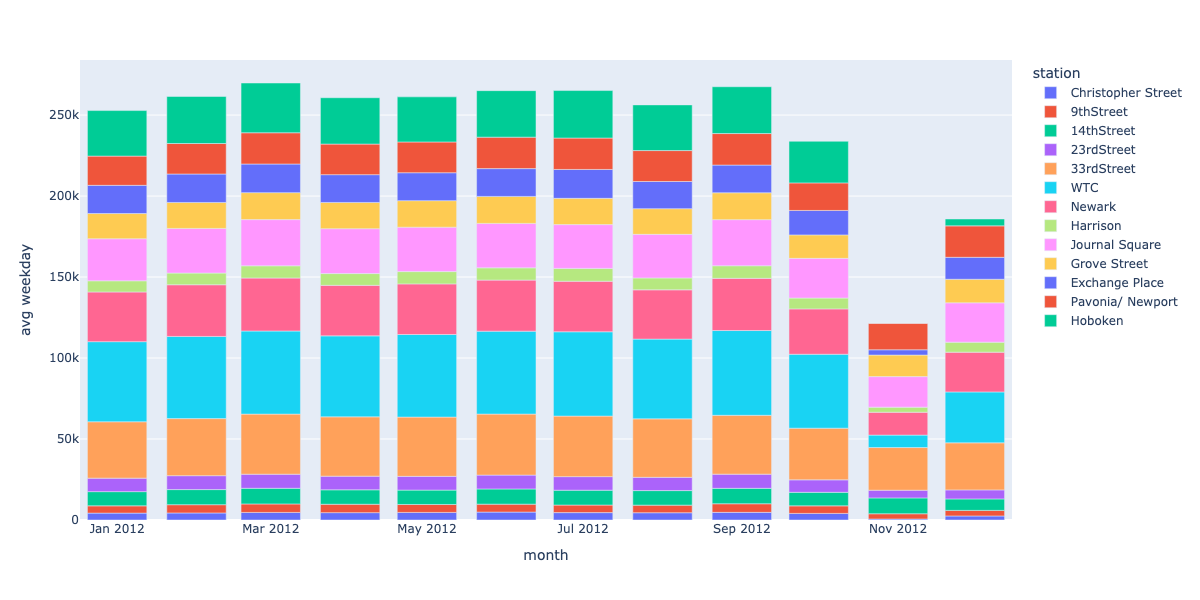

In [22]:
fig = px.bar(
    avgs[~avgs.station.str.contains('TOTAL')],
    x='month', y='avg weekday', color='station',
)
Image(fig.to_image(width=1200, height=600))